# Seminar 2

In this seminar we train different VAD models.

Dataset: https://disk.yandex.ru/d/LJlkc_WMo-libA

Hint to download from yadisk. To get real download link for wget or curl you need:
- Open developer console and go to the network tab
- Press download button
- find "download-url" on the network tab and copy

In [3]:
# download dataset
!wget -O data.tar.gz "https://downloader.disk.yandex.ru/disk/eaf745dbf77caaa85931a6377b31ae78f8206b70def86dd1406b308417390c0b/65bfdcff/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg%3D%3D?uid=0&filename=vad.tar.gz&disposition=attachment&hash=xNl9zyY4MVv885ADo3YdxK0cjYUJpvBOFDMBce1v/nqkkt6F5riqtEefvUDL1r5nq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=24567283&hid=d194eddc3de0a89d9208c5e452965d10&media_type=compressed&tknv=v2"
!tar -xvf data.tar.gz

--2024-02-04 17:53:08--  https://downloader.disk.yandex.ru/disk/eaf745dbf77caaa85931a6377b31ae78f8206b70def86dd1406b308417390c0b/65bfdcff/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg%3D%3D?uid=0&filename=vad.tar.gz&disposition=attachment&hash=xNl9zyY4MVv885ADo3YdxK0cjYUJpvBOFDMBce1v/nqkkt6F5riqtEefvUDL1r5nq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=24567283&hid=d194eddc3de0a89d9208c5e452965d10&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 2a02:6b8::2:127, 77.88.21.127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|2a02:6b8::2:127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s445vlx.storage.yandex.net/rdisk/eaf745dbf77caaa85931a6377b31ae78f8206b70def86dd1406b308417390c0b/65bfdcff/gtj3WQiuHGabqHv6W0pVHOyU6CN1oLeAGkDn-ZPe-6Z75o5sV1YhDnlc8TB5qaMgrsRNF3AQ5jVmqM_7KWldtg==?uid=0&filename

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio

import IPython

In [5]:
DATADIR = 'data'
WAVDIR = os.path.join(DATADIR, 'wav')
ALIGNDIR = os.path.join(DATADIR, 'align')
FS = 16000
FRAME = 30 * FS // 1000
TRAIN = 350

In [6]:
class Dataset:
    def __init__(self):
        uttids = [uttid.split('.')[0] for uttid in os.listdir(WAVDIR)]
        self._data = []
        for uttid in uttids:
            wav_path = os.path.join(WAVDIR, f'{uttid}.wav')
            wav, fs = torchaudio.load(wav_path)
            assert fs == FS
            align = np.load(os.path.join(ALIGNDIR, f'{uttid}.npy'))
            while align.shape[0] * FRAME > wav.shape[1]:
                align = align[:-1]
            self._data.append((wav[:, :align.shape[0] * FRAME], align, wav_path))

    def __getitem__(self, idx: int):
        return self._data[idx]
    
    def __len__(self):
        return len(self._data)
    
dataset = Dataset()

### Sample

Let's take a look at audiofile, its waveform and its align targets: 

In [7]:
IPython.display.Audio(dataset[0][2])

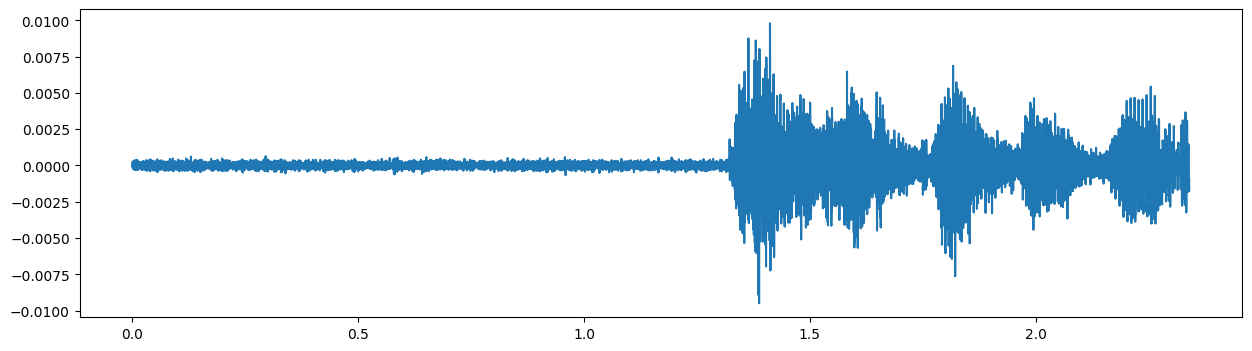

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, dataset[0][0].shape[1] / FS, 1 / FS), dataset[0][0][0])
plt.show()

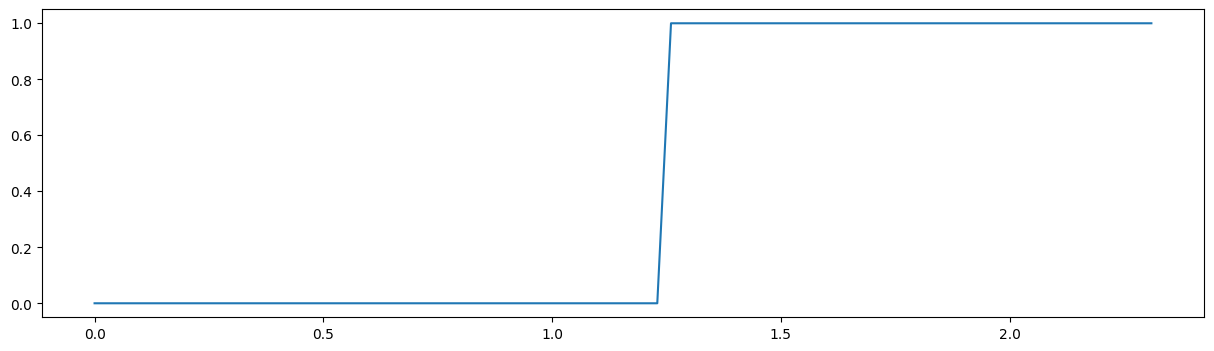

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, dataset[0][1].shape[0] * 0.03 - 1e-6, 0.03), dataset[0][1])
plt.show()

### Score and Tuning

A large number of metrics can be used for the vad task. Let's try to implement the following:
- Per-frame Accuracy $\frac{\sum_i^N \sum_j^{A_i} I(A_{ij} = P_{ij})}{\sum_i^N \sum_j^{A_i} 1}$
- Per-frame Accuracy with utterance normalization $\frac{1}{N} \sum_i^N \frac{\sum_j^{A_i} I(A_{ij} = P_{ij})}{\sum_j^{A_i} 1}$
- Intersection-over-Union $\frac{1}{N} \sum_i^N \frac{\sum_j^{A_i} I(A_{ij} = P_{ij} = 1)}{\sum_j^{A_i} I(A_{ij} = 1 || P_{ij} = 1)}$

where:
- $N$ -- number of utterances
- $A_{ij}$ -- target for $j$-th frame of $i$-th utterance
- $P_{ij}$ -- predict for $j$-th frame of $i$-th utterance

In [91]:
def score(probs: list[np.ndarray], aligns: list[np.ndarray], thr: float = 0.5):
    preds = [prob > thr for prob in probs]
    acc1 = ?
    acc2 = ?
    iou = ?
    return f'Per-frame acc: {acc1}, Per-frame in utterance acc {acc2}, IoU: {iou}'

Let's write function to find optimal thresholds for per-frame Accuracy metric:

In [92]:
def optimal_thresold(preds, align):
    return best_thr, best_acc

### Energy VAD

Energy for one frame can be calculated as follows:
$$\frac{1}{N} \sum_i^N x_i^2$$
Where $N$ -- number of amplitudes in frame, $x_i$ -- $i$-th amplitude value.

We can get rid of $\frac{1}{N}$ in this formula, if all frames has the same size.

In [93]:
Y = np.concatenate([item[1] for item in dataset[:TRAIN]])
X = np.array(np.split(np.concatenate([item[0][0] for item in dataset[:TRAIN]]), Y.shape[0]))
Y_test = np.concatenate([item[1] for item in dataset[TRAIN:]])
X_test = np.array(np.split(np.concatenate([item[0][0] for item in dataset[TRAIN:]]), Y_test.shape[0]))
parts = np.cumsum([item[1].shape[0] for item in dataset[TRAIN:]])[:-1]
train_preds = ?
thr, train_acc = optimal_thresold(train_preds, Y)
test_preds = ?
test_score = score(np.split(test_preds, parts), np.split(Y_test, parts), thr)
print(train_acc, test_score)

0.9011240795864014 Per-frame acc: 0.9042538702501476, Per-frame in utterance acc 0.8935556547197742, IoU: 0.6726715866328522


### Linear VAD

Let's try to use simple binary classification model for each frame.

In [ ]:
def frame_classification(transform: nn.Module):
    X = np.concatenate([transform(item[0])[0].T.data.numpy()[:-1, :] for item in dataset[:TRAIN]])
    Y = np.concatenate([item[1] for item in dataset[:TRAIN]])
    X_test = np.concatenate([transform(item[0])[0].T.data.numpy()[:-1, :] for item in dataset[TRAIN:]])
    Y_test = np.concatenate([item[1] for item in dataset[TRAIN:]])
    parts = np.cumsum([item[1].shape[0] for item in dataset[TRAIN:]])[:-1]
    ...
    thr, train_acc = optimal_thresold(train_preds, Y)
    test_score = score(np.split(test_preds, parts), np.split(Y_test, parts), thr)
    print(train_acc, test_score)

In [ ]:
frame_classification(torchaudio.transforms.MelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=23))

In [ ]:
frame_classification(
    torchaudio.transforms.MFCC(n_mfcc=13, melkwargs={'n_mels': 23, 'n_fft': FRAME, 'hop_length': FRAME})
)

### NN VAD

Let's try to aggregate adjacent frames:

In [ ]:
def multiframe_classification(transform: nn.Module, model: nn.Module):
    ...
    print(train_acc, test_score)

In [ ]:
multiframe_classification(
    torchaudio.transforms.MelSpectrogram(n_fft=FRAME, hop_length=FRAME, n_mels=23),
    nn.Sequential(nn.Conv1d(23, 23, 5, padding=2), nn.ReLU(), nn.Conv1d(23, 1, 1), nn.Sigmoid())
)

In [ ]:
multiframe_classification(
    torchaudio.transforms.MFCC(n_mfcc=13, melkwargs={'n_mels': 23, 'n_fft': FRAME, 'hop_length': FRAME}),
    nn.Sequential(nn.Conv1d(13, 23, 5, padding=2), nn.ReLU(), nn.Conv1d(23, 1, 1), nn.Sigmoid())
)

### Check model errors

Let's try to get some previous model and use it to make prediction.
After that, let's look at the utterances with the worst score.

In [ ]:
...